In [1]:
import os

if not os.environ.get('WEBBPSF_PATH'):
    print("WEBBPSF_PATH couldn't found")
    #os.environ['WEBBPSF_PATH'] = '/data/webbpsf-data'
    
import sys
import time

import numpy as np

import pandas as pd

import glob as glob

import urllib.request

import tarfile

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.detection import DAOStarFinder
from photutils import EPSFBuilder, GriddedPSFModel
from photutils.psf import DAOGroup, extract_stars, IterativelySubtractedPSFPhotometry

import jwst
from jwst.datamodels import ImageModel

import webbpsf # Must follow this instruction -> https://webbpsf.readthedocs.io/en/stable/installation.html
from webbpsf.utils import to_griddedpsfmodel

import pysynphot  # Must follow this instruction -> https://pysynphot.readthedocs.io/en/latest/#installation-and-setup

from collections import OrderedDict
from astropy.wcs import WCS

/home/bariskurtkaya/miniconda3/envs/jwst/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /my/local/dir/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/bariskurtkaya/miniconda3/envs/jwst/lib/python3.10/site-packages/pysynphot/refs.py:117: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /my/local/dir/trds/mtab/*_tmg.fits
  warnings.warn('No graph or component tables found; '
/home/bariskurtkaya/miniconda3/envs/jwst/lib/python3.10/site-packages/pysynphot/refs.py:124: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /my/local/dir/trds/mtab/*_tmt.fits
  warnings.warn('No thermal tables found, '


In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 20

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

In [3]:
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987, 1.103, 1.298, 1.553, 1.628, 1.770, 1.801, 1.494, 1.990, 2.060, 2.141, 2.304, 2.341, 1.340,
            1.444, 1.585, 1.547, 1.711, 1.760, 1.830, 1.901, 2.165, 2.179, 2.300, 2.302, 2.459, 2.507, 2.535, 2.574]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

In [4]:
# Path containing the rateints data
PROPOSAL_ID = '1386'
INSTRUME = 'NIRCAM'
#DETECTOR = 'nrca2'
#directory = f'/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/{INSTRUME}/{PROPOSAL_ID}/mastDownload/JWST/'
directory = f'/data/scratch/bariskurtkaya/dataset/{INSTRUME}/{PROPOSAL_ID}/mastDownload/JWST/'

In [5]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_filter_short = {}
dict_filter_long = {}

ff_short = []
det_short = []
det_long = []
ff_long = []
detlist_short = []
detlist_long = []
filtlist_short = []
filtlist_long = []

images = sorted(glob.glob(os.path.join(directory, '*psfstack.fits')))
for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'NRCBLONG':
        d = 'NRCB5'
    elif d == 'NRCALONG':
        d = 'NRCA5'
    else:
        d = d

    wv = float(f[1:3])

    if wv > 24:         
        ff_long.append(f)
        det_long.append(d)

    else:
        ff_short.append(f)
        det_short.append(d)   

    detlist_short = sorted(list(dict.fromkeys(det_short)))
    detlist_long = sorted(list(dict.fromkeys(det_long)))

    unique_list_filters_short = []
    unique_list_filters_long = []

    for x in ff_short:

        if x not in unique_list_filters_short:

            dict_filter_short.setdefault(x, {})

    for x in ff_long:
        if x not in unique_list_filters_long:
            dict_filter_long.setdefault(x, {})   

    for d_s in detlist_short:
        dict_images[d_s] = dict_filter_short

    for d_l in detlist_long:
        dict_images[d_l] = dict_filter_long

    filtlist_short = sorted(list(dict.fromkeys(dict_filter_short)))
    filtlist_long = sorted(list(dict.fromkeys(dict_filter_long)))

    if len(dict_images[d][f]) == 0:
        dict_images[d][f] = {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)

print("Available Detectors for SW channel:", detlist_short)
print("Available Detectors for LW channel:", detlist_long)
print("Available SW Filters:", filtlist_short)
print("Available LW Filters:", filtlist_long)

Available Detectors for SW channel: []
Available Detectors for LW channel: ['NRCA5']
Available SW Filters: []
Available LW Filters: ['F250M', 'F300M', 'F356W', 'F410M', 'F444W']


In [6]:
dict_images

{'NRCA1': {},
 'NRCA2': {},
 'NRCA3': {},
 'NRCA4': {},
 'NRCA5': {'F250M': {'images': ['/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/jw01386-a3001_t002_nircam_f250m-maskrnd-sub320a335r_psfstack.fits']},
  'F300M': {'images': ['/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/jw01386-a3001_t002_nircam_f300m-maskrnd-sub320a335r_psfstack.fits']},
  'F356W': {'images': ['/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/jw01386-a3001_t002_nircam_f356w-maskrnd-sub320a335r_psfstack.fits']},
  'F410M': {'images': ['/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/jw01386-a3001_t002_nircam_f410m-maskrnd-sub320a335r_psfstack.fits']},
  'F444W': {'images': ['/data/scratch/bariskurtkaya/dataset/NIRCAM/1386/mastDownload/JWST/jw01386-a3001_t002_nircam_f444w-maskrnd-sub320a335r_psfstack.fits']}},
 'NRCB1': {},
 'NRCB2': {},
 'NRCB3': {},
 'NRCB4': {},
 'NRCB5': {}}

In [7]:
det = 'NRCA5'
filt = 'F250M'

im = fits.open(dict_images[det][filt]['images'][0])

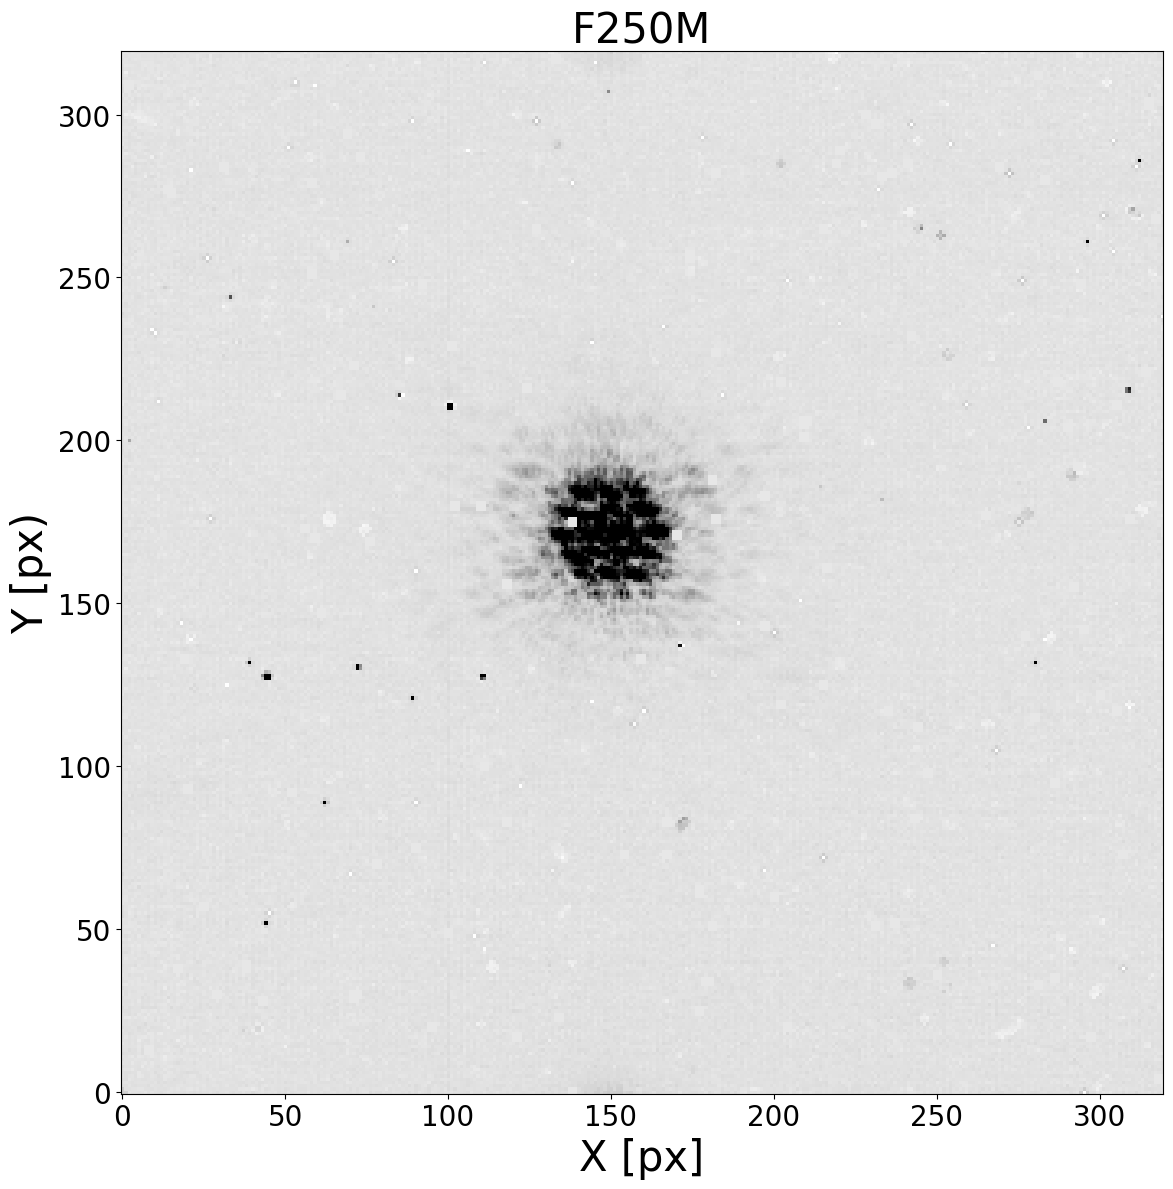

In [8]:
plt.figure(figsize=(12, 12))
   
data_sb = im[1].data

ax = plt.subplot(1, 1, 1)

plt.xlabel("X [px]")
plt.ylabel("Y [px)")
plt.title(filt)
norm = simple_norm(data_sb, 'sqrt', percent=99.)

ax.imshow(data_sb[0], norm=norm, cmap='Greys')

plt.tight_layout();

In [9]:
imh = im[1].header
data = data_sb / imh['PHOTMJSR']
print('Conversion factor from {units} to DN/s for filter {f}:'.format(units=imh['BUNIT'], f=filt), imh['PHOTMJSR'])
#area = im[4].data
#data = data * area

Conversion factor from MJy/sr to DN/s for filter F250M: 9.352245330810547


In [10]:
def create_psf_model(det='NRCA5', filt='F250M', fov=11, source=None, create_grid=False, num=9, save_psf=False, 
                     detsampled=False):

    nrc = webbpsf.NIRCam()

    nrc.detector = det 
    nrc.filter = filt

    print("Using a {field}".format(field=fov), "px fov")

    if create_grid:
        print("")
        print("Creating a grid of PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = num
        
        if save_psf:
            
            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)

        else:
        
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               use_detsampled_psf=detsampled)
            
    else:
        print("")
        print("Creating a single PSF for filter {filt} and detector {det}".format(filt=filt, det=det))
        print("")
        num = 1
        
        if save_psf:

            outname = 'PSF_%s_samp4_fov%d_npsfs%d.fits' % (filt, fov, num)
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               save=True, outfile=os.path.join(psfs_dir,outname), use_detsampled_psf=detsampled)
        
        else:
      
            psf = nrc.psf_grid(num_psfs=num, oversample=4, source=source, all_detectors=False, fov_pixels=fov, 
                               use_detsampled_psf=detsampled)
        
    return psf     

In [11]:
filtlist_long

['F250M', 'F300M', 'F356W', 'F410M', 'F444W']

In [33]:
psfs_dir = '/data/scratch/bariskurtkaya/PSF_MODELS/'

if not os.path.exists(psfs_dir):
    os.makedirs(psfs_dir)

for i in filtlist_long:
    
    psf_webbpsf_single = create_psf_model(det='NRCA5', filt=i, fov=160, source=None, create_grid=False, save_psf=True, 
                                      detsampled=False)

Using a 160 px fov

Creating a single PSF for filter F250M and detector NRCA5


Running instrument: NIRCam, filter: F250M
  Running detector: NRCA5
    Position 1/1: (1023, 1023) pixels
    Position 1/1 centroid: (319.45693105688434, 319.5579209561635)
  Saving file: /data/scratch/bariskurtkaya/PSF_MODELS/PSF_F250M_samp4_fov160_npsfs1_nrca5.fits
Using a 160 px fov

Creating a single PSF for filter F300M and detector NRCA5


Running instrument: NIRCam, filter: F300M
  Running detector: NRCA5
    Position 1/1: (1023, 1023) pixels
    Position 1/1 centroid: (319.43412688176437, 319.54483711207865)
  Saving file: /data/scratch/bariskurtkaya/PSF_MODELS/PSF_F300M_samp4_fov160_npsfs1_nrca5.fits
Using a 160 px fov

Creating a single PSF for filter F356W and detector NRCA5


Running instrument: NIRCam, filter: F356W
  Running detector: NRCA5
    Position 1/1: (1023, 1023) pixels
    Position 1/1 centroid: (319.4332607891508, 319.53348360784446)
  Saving file: /data/scratch/bariskurtkaya/PSF_MOD

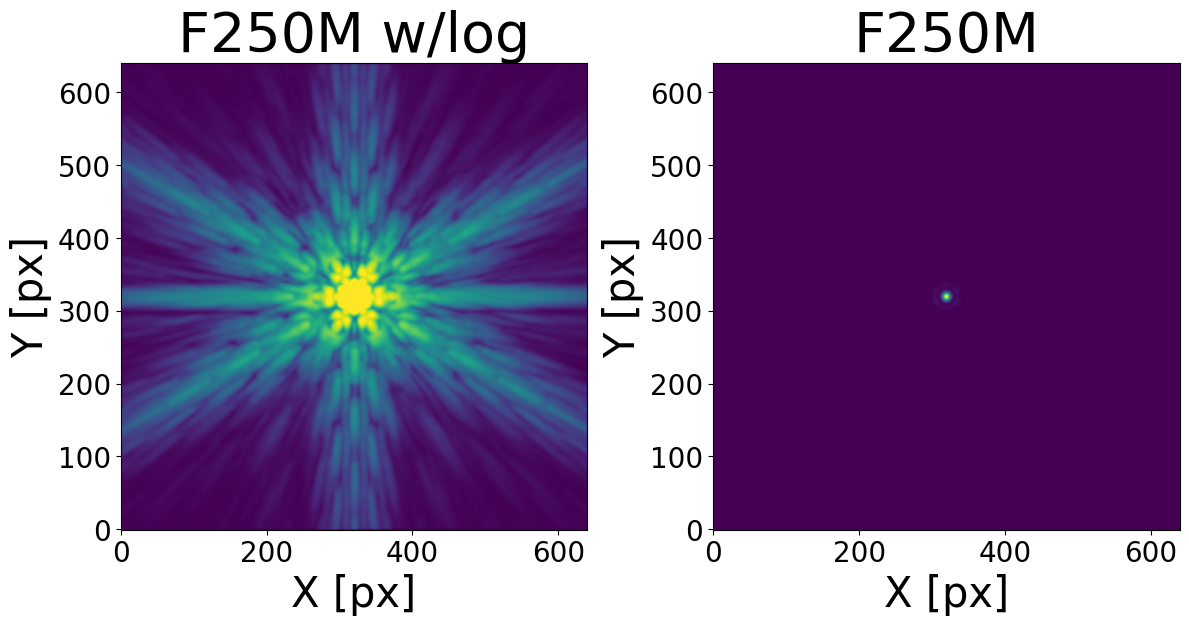

In [34]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(1, 2, 1)

norm_psf = simple_norm(psf_webbpsf_single.data[0], 'log', percent=99.)
ax.set_title(filt + ' w/log', fontsize=40)
ax.imshow(psf_webbpsf_single.data[0], norm=norm_psf)
ax.set_xlabel('X [px]', fontsize=30)
ax.set_ylabel('Y [px]', fontsize=30)

ax = plt.subplot(1, 2, 2)
ax.set_title(filt, fontsize=40)
ax.imshow(psf_webbpsf_single.data[0])
ax.set_xlabel('X [px]', fontsize=30)
ax.set_ylabel('Y [px]', fontsize=30)

plt.tight_layout()

In [35]:
psf_webbpsf_single.data.shape, np.max(psf_webbpsf_single.data), np.min(psf_webbpsf_single.data)

((1, 640, 640), 0.11465686983951132, 1.3889324867370178e-09)